In [1]:
%matplotlib inline

In [2]:
import os
import cv2
import keras

import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda, Reshape, Flatten, ZeroPadding2D, Layer
from keras.models import Model
from sklearn.model_selection import train_test_split

from data_generator import DataGen

Using TensorFlow backend.


In [3]:
DATA_DIR = './data/data_simple_movement/cartesian/'
HEIGHT = 100
WIDTH = 100
NUM_CHANNEL = 2

In [4]:
input_img = Input(shape=(HEIGHT, WIDTH, NUM_CHANNEL))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 100, 2)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 16)      304       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 8)         584       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 13, 13, 8)         0         
__________

In [5]:
dgen = DataGen(HEIGHT, WIDTH, NUM_CHANNEL)
x, y = dgen.get_data(path=os.path.abspath(DATA_DIR),
                     target_mmc_out=False,
                     size=8,
                     channel_first=False)

x = x / 255.
y = y / 255.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, shuffle=True)

autoencoder.fit(x_train, y_train,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(x_test, y_test))

Train on 86 samples, validate on 10 samples
Epoch 1/100
86/86 [==============================] - 5s 60ms/step - loss: 0.6732 - val_loss: 0.6236
Epoch 2/100
86/86 [==============================] - 2s 29ms/step - loss: 0.5111 - val_loss: 0.2832
Epoch 3/100
86/86 [==============================] - 2s 29ms/step - loss: 0.2091 - val_loss: 0.2273
Epoch 4/100
86/86 [==============================] - 2s 29ms/step - loss: 0.1998 - val_loss: 0.1655
Epoch 5/100
86/86 [==============================] - 2s 29ms/step - loss: 0.1669 - val_loss: 0.1608
Epoch 6/100
86/86 [==============================] - 2s 29ms/step - loss: 0.1573 - val_loss: 0.1513
Epoch 7/100
86/86 [==============================] - 3s 29ms/step - loss: 0.1487 - val_loss: 0.1448
Epoch 8/100
86/86 [==============================] - 3s 33ms/step - loss: 0.1404 - val_loss: 0.1343
Epoch 9/100
86/86 [==============================] - 3s 33ms/step - loss: 0.1302 - val_loss: 0.1242
Epoch 10/100
86/86 [==============================] - 3s

In [6]:
decoded_imgs = autoencoder.predict(x_test)

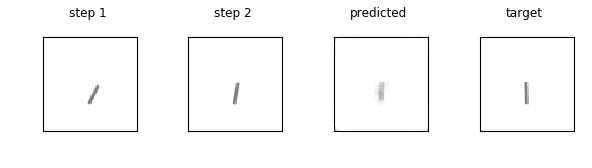

In [13]:
idx = 3  # change index for differnet test image

fig, axes = plt.subplots(figsize=((10, 3)), nrows=1, ncols=NUM_CHANNEL+2)

# display input images
for i, ax in enumerate(axes.flat[:NUM_CHANNEL]):
    ax.imshow(x_test[idx][:, :, i].reshape(HEIGHT, WIDTH), cmap='gray')
    ax.axis('off'), ax.set_title('step ' + str(i+1))
    
# display prediction
axes[NUM_CHANNEL].imshow(decoded_imgs[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
axes[NUM_CHANNEL].axis('off'), axes[NUM_CHANNEL].set_title('predicted')

# display target
axes[NUM_CHANNEL+1].imshow(y_test[idx][:, :, 0].reshape(HEIGHT, WIDTH), cmap='gray')
axes[NUM_CHANNEL+1].axis('off'), axes[NUM_CHANNEL+1].set_title('target')

plt.show()